# Quantum Circuit Learning para un problema de clasificación

Reproduciomos los resultados en el trabajo de Mitarai et al. que muestran la implementación del Quantum Circuit Learning para realizar una clasificación no lineal simple. Usamos la librería qulacs para la simulación de circuitos cuánticos. Esta implementación se basa en el tutorial provisto en la documentación de qulacs: https://dojo.qulacs.org/ja/latest/notebooks/5.1_variational_quantum_eigensolver.html 

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from functools import reduce
from qulacs import QuantumState, QuantumCircuit
from qulacsvis import circuit_drawer



import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.cm import ScalarMappable
from cycler import cycler
mpl.rcParams.update({'font.size': 18})

plt.rcParams['axes.axisbelow'] = True

## seed of random number
random_seed = 0
## initialization of random number generator
np.random.seed(random_seed)

Nuevamente utilizamos un circuito de 6 qubits y profundidad 6

In [2]:
########  Parameter  #############
nqubit = 6 ## number of qubit
c_depth = 6 ## depth of circuit

Generamos 100 muestras de entrenamiento, de las cuales la mitad pertenece a la clase 0 y la otra mitad a la 1. 

Los datos de entrada estarán dados por vectores de dos coordenadas $\mathbf{x}_i = (x_{i,0},x_{i,1})$ y las etiquetas $f(\mathbf{x}_i)$ estarán dadas por vectores $(1,0)$ para la clase 0 y $(0,1)$ para la clase 1.

In [3]:
## seed of random number
random_seed = 0
## initialization of random number generator
np.random.seed(random_seed)
np.random.seed(0)

num_training_samples = 100 # generate 100 teaching samples of each class

# 100 random samples in class 0
r_min = 0.; r_max = 0.49
r_train = r_min + (r_max - r_min) * np.random.rand(num_training_samples) # random ratio in [0,0.5]
theta_train = 2.0 * np.pi * np.random.rand(num_training_samples) # random angle

# we store the x_0 and x_1 coordinates of class 0 training samples
x_0_class0 = r_train * np.cos(theta_train) 
x_1_class0= r_train * np.sin(theta_train)
# these samples will be labeled as class 0, which corresponds to the teaching value [0,1]
f_train0 = [np.asarray([0,1]) for i in range(num_training_samples)] # corresponding labels

# 100 samples in class 1
r_min = 0.51; r_max = 1.0
r_train = r_min + (r_max - r_min) * np.random.rand(num_training_samples)
theta_train = 2.0 * np.pi * np.random.rand(num_training_samples)

# we store the x and y coordinates of class 1 training samples
x_0_class1 = r_train * np.cos(theta_train)
x_1_class1= r_train * np.sin(theta_train)
# these samples will be labeled as class 1, which corresponds to the teaching value [1,0]
f_train1 = [np.asarray([1,0]) for i in range(num_training_samples)]

# we concatenate the two sets of samples
x_train = np.concatenate([x_0_class0, x_0_class1])
y_train = np.concatenate([x_1_class0, x_1_class1])
f_train = f_train0 + f_train1
train_samples = [np.asarray([x_train[i], y_train[i]]) for i in range(len(x_train))]


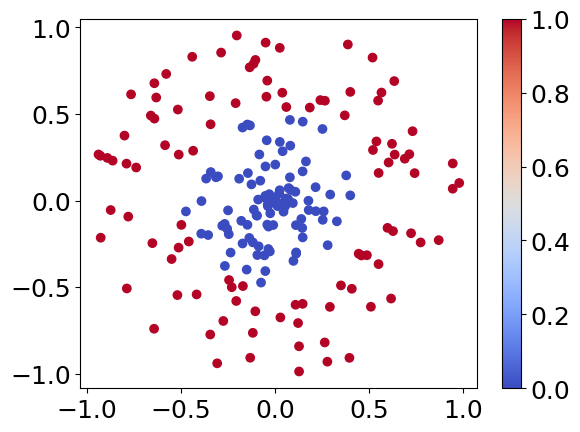

In [4]:
color = [f[0]**2 for f in f_train]
plt.scatter(x_train, y_train, c=color, cmap='coolwarm')
plt.colorbar()  # to show color scale
plt.show()

## Codificación de valores en estados cuánticos

Definimos el estado inicial como $\ket{\psi} = \ket{000000}$.

Siguiendo el trabajo de referencia definimos la compuerta de entrada:
$U_{in}(\vec{x_i}) = \Pi_j R^Z_j(\cos^{-1}x^2_{i,j \ mod \ 2}) R^Y_j(\sin^{-1}x_{i,j \ mod \ 2})$

Entonces el input $\vec{x_i}$, se convierte en: $\ket{\psi_{in}(\vec{x_i})} = U_{in}(\vec{x_i})\ket{00...0}$

In [6]:
def U_in(sample):
    U = QuantumCircuit(nqubit)

    for j in range(nqubit):
        jmod = j%2
        xij = sample[jmod]
        angle_y = np.arcsin(xij)
        angle_z = np.arccos(xij**2)
        U.add_RY_gate(j, angle_y)
        U.add_RZ_gate(j, angle_z)

    return U

In [10]:
# Test initial state
sample_i = train_samples[10]
print(f'sample = {sample_i}')

# Initial State
state = QuantumState(nqubit) # Initial state |000000>
state.set_zero_state()

U_in(sample_i).update_quantum_state(state) # calculation of U_in|000>
print('state: ')
print(np.round(state.get_vector(),8))

sample = [-0.36673254  0.1265258 ]
state: 
[ 8.1048587e-01-5.7867473e-01j -2.1129040e-02+4.7862120e-02j
  4.1950000e-04-2.1006400e-03j  3.7310000e-05+1.0617000e-04j
 -2.1129040e-02+4.7862120e-02j -3.2711000e-04-2.7290400e-03j
  3.7310000e-05+1.0617000e-04j -4.5300000e-06-3.8000000e-06j
  4.1950000e-04-2.1006400e-03j  3.7310000e-05+1.0617000e-04j
 -2.4300000e-06-3.9100000e-06j  2.1000000e-07+1.1000000e-07j
  3.7310000e-05+1.0617000e-04j -4.5300000e-06-3.8000000e-06j
  2.1000000e-07+1.1000000e-07j -1.0000000e-08+0.0000000e+00j
 -2.1129040e-02+4.7862120e-02j -3.2711000e-04-2.7290400e-03j
  3.7310000e-05+1.0617000e-04j -4.5300000e-06-3.8000000e-06j
 -3.2711000e-04-2.7290400e-03j  8.7880000e-05+1.1458000e-04j
 -4.5300000e-06-3.8000000e-06j  3.1000000e-07+5.0000000e-08j
  3.7310000e-05+1.0617000e-04j -4.5300000e-06-3.8000000e-06j
  2.1000000e-07+1.1000000e-07j -1.0000000e-08+0.0000000e+00j
 -4.5300000e-06-3.8000000e-06j  3.1000000e-07+5.0000000e-08j
 -1.0000000e-08+0.0000000e+00j  0.0000000e

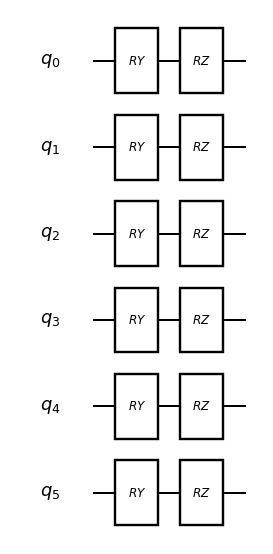

In [11]:
circuit_drawer(U_in(sample_i),'mpl')

In [13]:
## Basic gate
from qulacs.gate import X, Z
I_mat = np.eye(2, dtype=complex)
X_mat = X(0).get_matrix() # applied to qubit 0
Z_mat = Z(0).get_matrix() # applied to qubit 0

## Function that creates fullsize gate.
def make_fullgate(list_SiteAndOperator, nqubit):
    '''
    Take list_SiteAndOperator = [ [i_0, O_0], [i_1, O_1], ...],
    Insert Identity into unrelated qubit
    make (2**nqubit, 2**nqubit) matrix:
    I(0) * ... * O_0(i_0) * ... * O_1(i_1) ...
    '''
    list_Site = [SiteAndOperator[0] for SiteAndOperator in list_SiteAndOperator]
    list_SingleGates = [] ## Arrange 1-qubit gates and reduce with np.kron
    cnt = 0
    for i in range(nqubit):
        if (i in list_Site):
            list_SingleGates.append( list_SiteAndOperator[cnt][1] )
            cnt += 1
        else: ## an empty site is identity
            list_SingleGates.append(I_mat)

    return reduce(np.kron, list_SingleGates)

### Circuito Parametrizado

Se generan el operador evolución asociado al Hamiltoniano del circuito $H_{circ}$ y las compuertas de rotación parametrizadas por los valores $\theta$.
Creando el circuito variacional $U(\theta)$:

$U\left(\{ \theta^{(i)}_{j} \}_{i,j} \right) = \prod\limits_{i=1}^d \left( \left( \prod\limits_{j=1}^n U_{rot}(\theta_j^{(i)}) \right) . U_{rand} \right)$


In [16]:
time_step = 10 ## elapsed time of time evolution with random Hamiltonian
ham = np.zeros((2**nqubit,2**nqubit), dtype = complex)
for i in range(nqubit): ## i runs 0 to nqubit-1
    Jx = -1. + 2.*np.random.rand() ## random number in -1~1
    ham += Jx * make_fullgate( [ [i, X_mat] ], nqubit)
    for j in range(i+1, nqubit):
        J_ij = -1. + 2.*np.random.rand()
        ham += J_ij * make_fullgate ([ [i, Z_mat], [j, Z_mat]], nqubit)

## Create a time evolution operator by diagonalization. H*P = P*D <-> H = P*D*P^dagger
diag, eigen_vecs = np.linalg.eigh(ham)
time_evol_op = np.dot(np.dot(eigen_vecs, np.diag(np.exp(-1j*time_step*diag))), eigen_vecs.T.conj()) # e^-iHT

# Convert to qulacs gate
from qulacs.gate import DenseMatrix
time_evol_gate = DenseMatrix([i for i in range(nqubit)], time_evol_op)

In [17]:
from qulacs import ParametricQuantumCircuit

# Assemble output gate U_out & set initial parameter values
U_out = ParametricQuantumCircuit(nqubit)
for d in range(c_depth):
    U_out.add_gate(time_evol_gate)
    for i in range(nqubit):
        angle = 2.0 * np.pi * np.random.rand()
        U_out.add_parametric_RX_gate(i,angle)
        angle = 2.0 * np.pi * np.random.rand()
        U_out.add_parametric_RZ_gate(i,angle)
        angle = 2.0 * np.pi * np.random.rand()
        U_out.add_parametric_RX_gate(i,angle)

In [12]:
# Function that updates parameter theta
def set_U_out(theta):
    global U_out

    parameter_count = U_out.get_parameter_count()

    for i in range(parameter_count):
        U_out.set_parameter(i, theta[i])

Graficamos el circuito resultante:

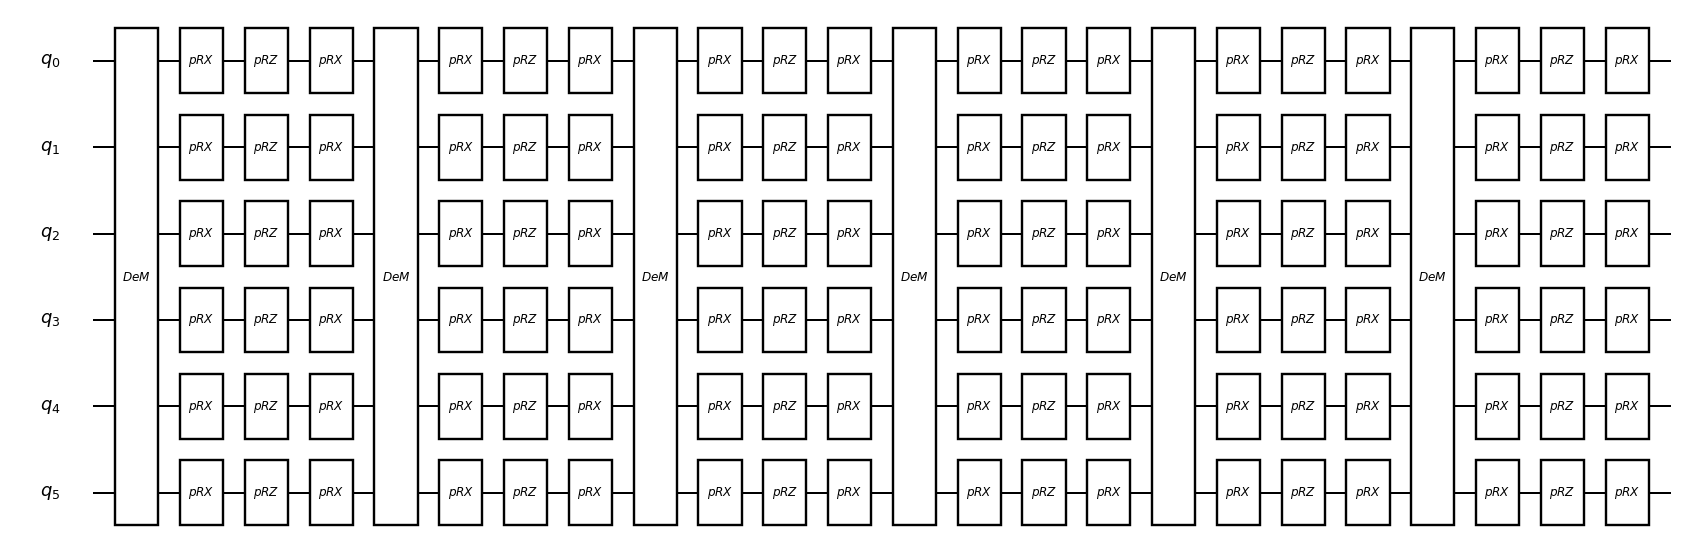

In [18]:
# Get the list of initial values of the parameter theta
parameter_count = U_out.get_parameter_count()
theta_init = [U_out.get_parameter(ind) for ind in range(parameter_count)]
circuit_drawer(U_out,'mpl')

## Medición

En este ejemplo, el output del modelo se obtendrá del valor de expectación del operador Z de Pauli de los dos primeros qubits. 
A estos valores luego los transformaremos usando la función softmax $\mathbf{F}$. 

Para el vector d-dimensional $\mathbf{q}$, la función softmax devuelve el vector d-dimensional $\mathbf{F(\mathbf{q})}$, donde el k-ésimo elemento es $\mathbf{F_k(\mathbf{q})} = e^{q_k}/\sum_i e^{q_i}$

In [13]:
def softmax(v):
    e_k = np.exp(v - np.max(v))
    return e_k / e_k.sum(axis=0)

Así, $y(\theta,x_i)=\mathbf{F} (\left<\psi_\text{out}|Z_0|\psi_\text{out}\right> , \left<\psi_\text{out}|Z_1|\psi_\text{out}\right>) $

In [14]:
# Create observable Z_0
from qulacs import Observable

def get_output(state):

    z0 = Observable(nqubit)
    z0.add_operator(1.,'Z 0') # a = 1
    z0_val = z0.get_expectation_value(state)

    z1 = Observable(nqubit)
    z1.add_operator(1.,'Z 1') # a = 1
    z1_val = z1.get_expectation_value(state)

    res = softmax(np.asarray([z0_val, z1_val]))
    
    return res

Usando este ouput definimos la función de predicción.

In [15]:
# Function that gives prediction value y(x_i, theta) of the model from input x_i
def qcl_pred(sample, U_out):
    state = QuantumState(nqubit)
    state.set_zero_state()

    # Calculate input state
    U_in(sample).update_quantum_state(state)

    # Calculate output state
    U_out.update_quantum_state(state)

    # Output of the model
    res =get_output(state)

    return res

Como función perdida utilizamos la función ```cross_entropy```, que es muy comunmente utilizada en problemas de clasificación.

In [16]:
def cross_entropy(f_pred, f_train):
    loss = 0
    for i in range(len(f_pred)):
        for k in range(2):
            loss +=-f_train[i][k] * np.log(f_pred[i][k])

    return loss


In [17]:
# Calculate cost function L
def cost_func(theta):
    '''
    theta: ndarray of length c_depth * nqubit * 3
    '''
    # update the parameter theta of U_out
    # global U_out
    set_U_out(theta)

    # calculate basing on data of num_x_train in total
    predicted_output = [qcl_pred(sample, U_out) for sample in train_samples]

    # quadratic loss
    L = cross_entropy(predicted_output, f_train)

    return L

## Minimización

Usamos el método BFGS para minimizar la función costo.

In [18]:
from scipy.optimize import minimize

result = minimize(cost_func, theta_init, method='BFGS')
result.fun

96.08739487973268

## Testeo

Generamos una grilla de valores para aplicar el modelo optimizado. Se puede ver que logra clasificar de forma apropiada los valores en ambas clases.

In [19]:
x = np.linspace(-1, 1, 25)
y = np.linspace(-1, 1, 25)

# Create a meshgrid
x_test, y_test = np.meshgrid(x, y)
x_test = x_test.flatten()
y_test = y_test.flatten()

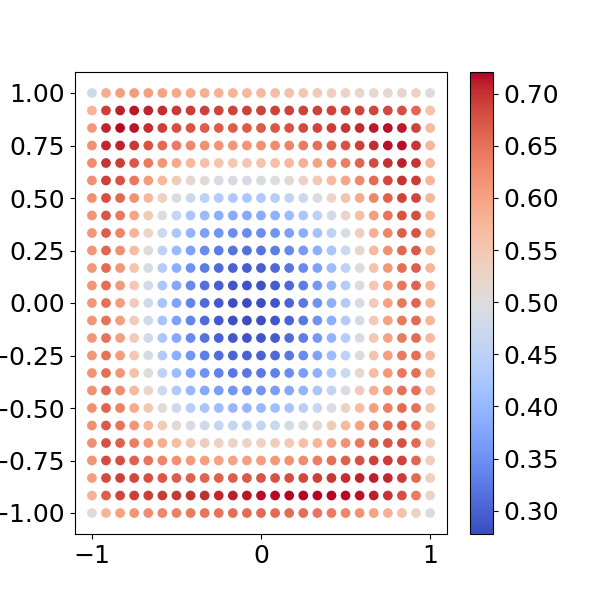

In [21]:
fig,axs = plt.subplots(1,figsize=(6,6))
test_samples = [np.asarray([x_test[i],y_test[i]]) for i in range(len(x_test))]
# Initial prediction
final_prediction = [qcl_pred(z, U_out) for z in test_samples]
color_final_pred = [p[0] for p in final_prediction]

plt.scatter(x_test, y_test, c=color_final_pred, cmap='coolwarm')
plt.colorbar()  # to show color scale
plt.show()

### References

[1] K. Mitarai, M. Negoro, M. Kitagawa, and K. Fujii, “Quantum circuit learning”, Phys. Rev. A 98, 032309 (2018), arXiv：https://arxiv.org/abs/1803.00745
